# Stochastic Optimization

## 1.1 Random Search

<a rel="license" href="http://creativecommons.org/licenses/by-sa/4.0/"><img alt="Creative Commons License" align="left" src="https://i.creativecommons.org/l/by-sa/4.0/80x15.png" /></a>&nbsp;| Dennis G. Wilson | <a href="https://supaerodatascience.github.io/stochastic/">https://supaerodatascience.github.io/stochastic/</a>

The basis of all stochastic optimization algorithms is randomly sampling the search space. Our first algorithm will be simply this: randomly sampling the search space, one point at a time, always sampling according to the same distribution.

We'll start by defining a search space using a common continuous optimization benchmark: the Rosenbrock function. Its two dimensional form is here:

$f(x, y)=(a-x)^2+B(y-x^2)^2$

In [1]:
def rosenbrock(x, y, a=1, B=100):
      return (a-x)**2 + B*((y-x**2))**2

This function is also available in its general form, which scales to $N$ dimensions, in `scipy`

In [2]:
from scipy.optimize import rosen

print(rosenbrock(0.1, 0.2))
print(rosen([0.1, 0.2]))

4.42
4.42


To understand this search space, we'll plot it.

In [3]:
%matplotlib widget
%matplotlib inline
%matplotlib notebook
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
from mpl_toolkits.mplot3d import Axes3D
import math

In [4]:
def plot_2d(X, Y, Z):
    fig = plt.figure(figsize=(8, 6))
    cs = plt.contourf(X, Y, Z, cmap=cm.nipy_spectral)
    fig.colorbar(cs)
    plt.show()
    
def plot_3d(X, Y, Z):
    fig = plt.figure(figsize=(6, 4))
    ax = fig.add_subplot(projection='3d')
    surf = ax.plot_surface(X, Y, Z, cmap=cm.nipy_spectral,
                       linewidth=0, antialiased=False)
    fig.colorbar(surf)
    plt.show()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
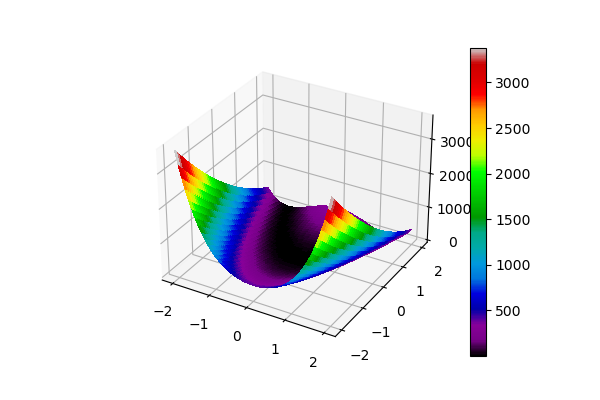

In [5]:
X = np.arange(-2, 2, 0.01)
Y = np.arange(-2, 2, 0.01)
X, Y = np.meshgrid(X, Y)
Z = rosenbrock(X, Y)
plot_3d(X, Y, Z)

As we can see, there is a minimum ridge area. Even using an uninformed search, this ridge should be easy to find. However, the global minimum is found at $(a, a^2)$, where $f(a, a^2) = 0$, and this exact point is very hard to find. In our case, this global minimum is at $(1, 1)$. Let's try to find it.

We'll first look at pure random search which uses a uniform distribution to sample the search space. Formally, we'll assume we're minimizing the function $f$ in

$f:[A, B]^n \rightarrow \mathbb{R}$

For the Rosenbrock function, this is not really true: the function is defined for all real number $\mathbb{R}$, so there are no minimum and maximum values for our uniform distribution, $A, B$ (besides infinity). We'll assume we're only optimizing between -2 and 2 for both dimensions, which is clearly cheating, but that's okay.

## Pure Random Search

    Initialize uniformly at random x ∈ Ω=[A, B]
    while not terminate
        Sample x′ uniformly at random in Ω
        if f(x′) < f(x)
            x = x'
    return x

References about pure random search (or uniform random search), for historical purposes:
+ S.H.  Brooks:  “Discussion  of  random  methods  for  locating  surface  maxima”.   Operations  Research  6  (1958),  pp.244–251.
+ L.A. Rastrigin: “The convergence of the random search method in the extremal control of a many-parameter system”.Automation and Remote Control 24 (1963), pp.  1337–1342.

<div class="alert alert-success">
    <h3>Exercise 1</h3>
    
Write a pure random search algorithm and apply it to the rosenbrock function. Let it run for 1000 evaluations (ie, 1000 calls to the `rosenbrock` function). What value does it converge to? Plot the convergence, keeping track of the best value f(x) over time. If you run it again, do the results change? If so, why?
    
Hint: for a uniform random number between A and B in python, you can use `np.random.rand()*(A-B)+B`
</div>

In [6]:
def prs(A=-2,B=2,n=1000):
    X = np.random.rand(n)*(A-B)+B
    Y = np.random.rand(n)*(A-B)+B
    cur_min = float("inf")
    for x in X :
        for y in Y :
            r = rosen([x, y])
            if r<cur_min :
                cur_min = r
    return cur_min

In [7]:
prs(n=1000)

8.705948782566483e-05

<div class="alert alert-info">
    <h3> Bonus exercise</h3>
    
While the Rosenbrock function has an exact minimum which is difficult to find, we see that uniform random search quickly descends to the valley where $f(x, y) \approx 0$. There are other problems which pure random search will have a much harder time with. A list of common functions can be found [here](https://coco.gforge.inria.fr/) and [here](https://en.wikipedia.org/wiki/Test_functions_for_optimization). As a bonus exercise, plot the Himmelblau function below and apply random search to it. Do you find the global optimum or a local optimum? Why?
</div>

In [ ]:
def himmelblau(x, y):
    return (x**2 + y - 11)**2 + (x + y**2 - 7)**2

Searching with a uniform distibution for each sample is completely uninformed: the best values the algorithm has found so far don't inform the next sampling. Clearly, by using these previous samples, we can inform where our algorithm should search next. That is the idea behind random optimization.

## Random Optimization

Let $f: \mathbb{R}^n → \mathbb{R}$ be the fitness or cost function which must be minimized. Let $x ∈ \mathbb{R}^n$ designate a position or candidate solution in the search-space.

    Initialize x randomly in ℝ
    while not terminate
        x' = x + N(0, 1)
        if f(x′) < f(x)
            x = x'
    return x

where $N(0,1)$ is a normal distribution centered at 0 with a standard deviation of 1.

<div class="alert alert-success">
    <h3>Exercise 2</h3>
    
Modify your pure random search algorithm to implement random optimization, using a Normal distribution now to find the next point. Apply it to the rosenbrock function and again let it run for 1000 evaluations. Does this improve over pure random search? Plot the comparison of the two. For bonus points, plot the comparison over multiple runs of the search algorithms and compare their average convergence.
</div>

In [28]:
def po(A=-2,B=2,n=1000):
    rosen_list = []
    X = [np.random.rand()*(A-B)+B,np.random.rand()*(A-B)+B]
    for i in range(n):
        X2 = X + np.random.randn(2)
        if rosen(X2) < rosen(X) :
            X = X2
        rosen_list.append(rosen(X))
    plt.plot(range(1,n+1),rosen_list)
    plt.yscale('log')
    return X,rosen(X)

(array([1.00184699, 0.99494029]), 0.007672105757791828)

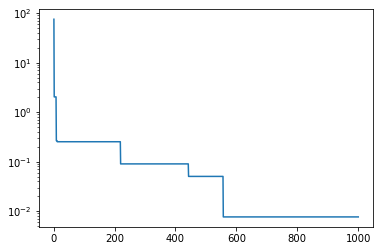

In [30]:
po(n=1000)

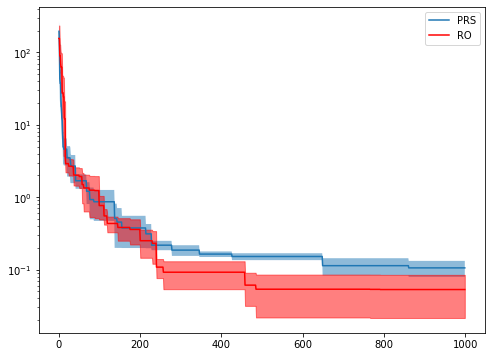

In [24]:
# %load solutions/2_ro.py
max_e = 1000
n_runs = 5
fs = np.zeros((n_runs, max_e))
for j in range(n_runs):
    min_f = np.Inf
    for i in range(max_e):
        x = np.random.rand()*4-2
        y = np.random.rand()*4-2
        f = rosenbrock(x, y)
        if f < min_f:
            min_f = f
        fs[j, i] = min_f
fs_mean = np.mean(fs, 0)
fs_std = np.std(fs, 0)

ro_fs = np.zeros((n_runs, max_e))
for j in range(n_runs):
    min_f = np.Inf
    x = np.random.rand()*4-2
    y = np.random.rand()*4-2
    for i in range(max_e):
        temp_x = x + np.random.randn()
        temp_y = y + np.random.randn()
        f = rosenbrock(temp_x, temp_y)
        if f < min_f:
            min_f = f
            x = temp_x
            y = temp_y
        ro_fs[j, i] = min_f
ro_fs_mean = np.mean(ro_fs, 0)
ro_fs_std = np.std(ro_fs, 0)

ax_x = range(max_e)
fig = plt.figure(figsize=(8, 6))
plt.fill_between(ax_x, fs_mean+0.5*fs_std, fs_mean-0.5*fs_std, alpha=0.5);
plt.plot(ax_x, fs_mean, label='PRS')
plt.fill_between(ax_x, ro_fs_mean+0.5*ro_fs_std, ro_fs_mean-0.5*ro_fs_std, alpha=0.5, color='r');
plt.plot(ax_x, ro_fs_mean, color='r', label='RO')
plt.yscale('log')
plt.legend()
plt.show();


<div class="alert alert-info">
    <h3>Discussion</h3>
    
The random optimization algorithm is exactly the (1+1) Evolutionary Strategy which we'll see in our next class and is also often referred to as "hill climbing". What are some points that could still be improved about this algorithm? Where is the search still uninformed?
</div>